**What does it change:**
1. Change the SMA crossover strategy to MACD crossover strategy.
  Why?
  MACD reacts more quickly to price changes compared to SMA, making it more responsive in trending markets. This can lead to earlier entry and exit signals.

2. Change the single ticker to a pair of tickers that allows for both long and short positions.
  Why?
  Utilize TQQQ for long positions when Long signal and SQQQ for short positions when Short signal. This allows to capitalize on market movements in both directions.

3. Incorporate a backtest module to accurately calculate gains and losses, providing valuable insights into the strategy's performance over historical data.

Finally result:
The results are unsatisfactory, with a 30% loss and a maximum drawdown of 24%. To mitigate this risk, we should implement a cut-loss strategy to reduce the maximum drawdown and enhance overall performance.





**SMA (Simple Moving Average) crossover strategy**

It is a type of **Trend Following** (momentum) strategy and onsists of a **leading** and a **lagging** simple moving averages.
Leading SMA has a **shorter look-back period** than lagging moving average. Hence, by definition, leading SMA will be more sensitive to most recent price moves; lagging SMA will be slower to react

*  **LONG**: if Leading (short-term) SMA cross above Lagging SMA
*  **SHORT**: if Leading (long-term) SMA cross below Lagging SMA

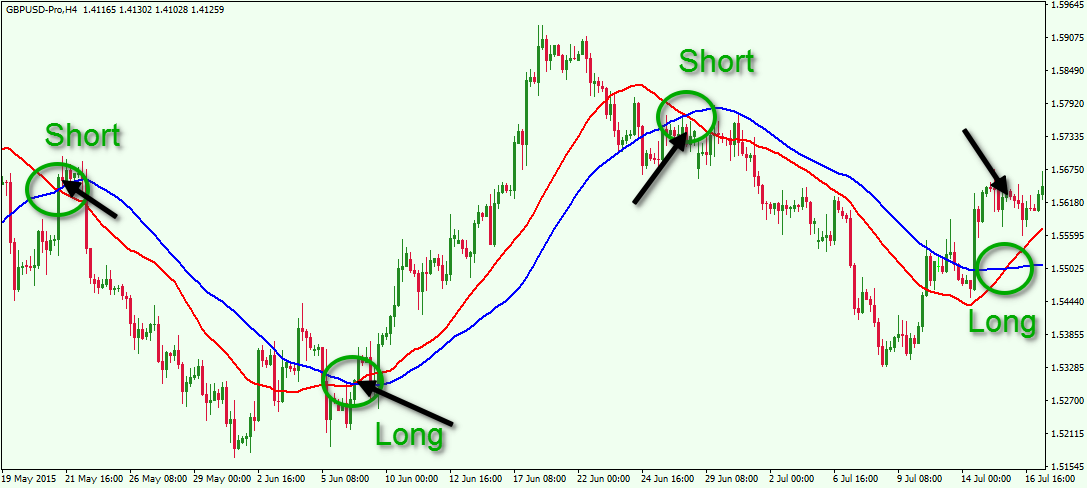


In [1]:
#@title Execute this block to start importing the libraries and helper functions
!pip install yfinance --upgrade
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import math
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None


!pip install -q pyfolio-reloaded
import pyfolio as pf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Interative charting
import altair as alt
alt.data_transformers.disable_max_rows()

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

SCREEN_X, SCREEN_Y = 12, 8

def test_ma(df, lead, lag, pc_thresh = 0.025):
    ma_df = df.copy()

    # build the lead/lag indicator
    ma_df['lead'] = ma_df['Close'].rolling(lead).mean()
    ma_df['lag'] = ma_df['Close'].rolling(lag).mean()

    # Remove the NaN rows
    ma_df.dropna(inplace = True)

    # calculate the lead and lag difference
    ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
    ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df['Close']

    # signal column will govern the buying and selling logic as described above;
    # 1 means that we are long, -1 means that we are short and 0 means no position
    ma_df['signal'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
    ma_df['signal'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['signal'])

    # Market column as log returns of price series - which is the simple buy-and-hold performance
    ma_df['Buy-Hold'] = np.log(ma_df['Close'] / ma_df['Close'].shift(1))

    # compute our Strategy returns by multiplying signal (shifted forward to match the Market column
    ma_df['Strategy'] = ma_df['signal'].shift(1) * ma_df['Buy-Hold']

    # perform a cumulative sum operation as well as apply an exponent on Market and Strategy log returns
    # in order to recover the original normalised series
    ma_df[['Buy-Hold','Strategy']] = ma_df[['Buy-Hold','Strategy']].cumsum().apply(np.exp)
    return ma_df


import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plot the OHLCV chart
def ohlcv(df, date, open, high, low, close, volume):
	rDf = df.reset_index()

	# Create subplots and mention plot grid size
	fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
				   vertical_spacing=0.03,
				   subplot_titles=('OHLC', 'Volume'),
				   row_width=[0.2, 0.7])

	fig.add_trace(go.Ohlc(x=rDf[date],
					  open=rDf[open],
					  high=rDf[high],
					  low=rDf[low],
					  close=rDf[close],
					  name="OHLC"),
					  row=1, col=1)

	# Bar trace for volumes on 2nd row without legend
	fig.add_trace(go.Bar(x=rDf[date], y=rDf[volume], showlegend=False), row=2, col=1)

	# Do not show OHLC's rangeslider plot
	fig.update(layout_xaxis_rangeslider_visible=False)

	fig.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 37.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
#@title 1: Download historical daily data from Yahoo Finance

ticker = 'TQQQ-SQQQ' # @param ["TQQQ-SQQQ", "UPRO-SPXU"] {allow-input: true}
startDate = '2020-01-01' #@param {type:"date"}

stock = yf.Ticker(ticker.split('-')[0])

# get stocks daily data OHLCV (Open/High/Low/Close/Volume) from Yahoo Finance
df= stock.history(start=startDate)
df.index = pd.to_datetime(df.index)
df.index.name = 'Date'

short = ticker.split('-')[1]
stock2 = yf.Ticker(short)
df2 = stock2.history(start=startDate)
df2.index = pd.to_datetime(df2.index)
df2.index.name = 'Date'
df[short] = df2['Close']

''' In case Yahoo finance doesn't work, download from github
url = 'https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/bitcoinHistorical.csv'
df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
'''

df

Open       High        Low      Close  \
Date                                                                    
2020-01-02 00:00:00-05:00  21.393403  21.907076  21.275235  21.907076   
2020-01-03 00:00:00-05:00  21.050955  21.704501  21.038896  21.311409   
2020-01-06 00:00:00-05:00  20.804966  21.723791  20.727795  21.716557   
2020-01-07 00:00:00-05:00  21.738266  21.892609  21.501929  21.690035   
2020-01-08 00:00:00-05:00  21.694855  22.495510  21.591155  22.189236   
...                              ...        ...        ...        ...   
2025-02-19 00:00:00-05:00  90.000000  91.120003  88.919998  90.400002   
2025-02-20 00:00:00-05:00  90.050003  90.230003  86.889999  89.300003   
2025-02-21 00:00:00-05:00  89.769997  89.790001  83.470001  83.709999   
2025-02-24 00:00:00-05:00  84.500000  85.050003  80.500000  80.699997   
2025-02-25 00:00:00-05:00  80.330002  80.379997  75.779999  77.620003   

                             Volume  Dividends  Stock Splits  Capital Gains  \
Date                                                                          
2020-01-02 00:00:00-05:00  65536000        0.0           0.0            0.0   
2020-01-03 00:00:00-05:00  72590000        0.0           0.0            0.0   
2020-01-06 00:00:00-05:00  64047600        0.0           0.0            0.0   
2020-01-07 00:00:00-05:00  53849600        0.0           0.0            0.0   
2020-01-08 00:00:00-05:00  79582400        0.0           0.0            0.0   
...                             ...        ...           ...            ...   
2025-02-19 00:00:00-05:00  34257900        0.0           0.0            0.0   
2025-02-20 00:00:00-05:00  40133000        0.0           0.0            0.0   
2025-02-21 00:00:00-05:00  59313600        0.0           0.0            0.0   
2025-02-24 00:00:00-05:00  53233700        0.0           0.0            0.0   
2025-02-25 00:00:00-05:00  75160900        0.0           0.0            0.0   

                                  SQQQ  
Date                                    
2020-01-02 00:00:00-05:00  2373.816162  
2020-01-03 00:00:00-05:00  2437.340576  
2020-01-06 00:00:00-05:00  2390.533203  
2020-01-07 00:00:00-05:00  2391.647461  
2020-01-08 00:00:00-05:00  2338.153076  
...                                ...  
2025-02-19 00:00:00-05:00    26.400000  
2025-02-20 00:00:00-05:00    26.760000  
2025-02-21 00:00:00-05:00    28.440001  
2025-02-24 00:00:00-05:00    29.469999  
2025-02-25 00:00:00-05:00    30.590000  

[1294 rows x 9 columns]

In [ ]:
# Save the dataframe to csv for downloading
df.to_csv('historical.csv')

#2: Visualize and understand the data (Exploratory Data Analysis)
Plot OHLCV (Open/High/Low/Close/Volume) candle sticks

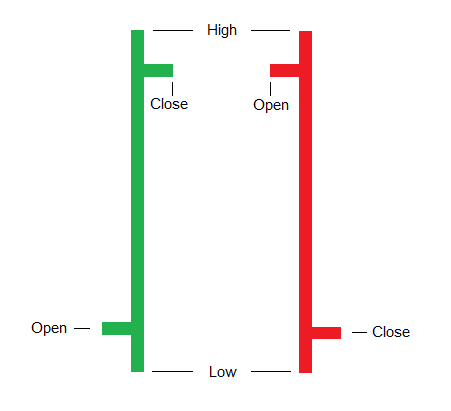

In [ ]:
# Filter the start date
#df = df.loc['2020-01-01':]

ohlcv(df, 'Date', 'Open', 'High', 'Low', 'Close', 'Volume')

count    1796.000000
mean        0.002086
std         0.044743
min        -0.344652
25%        -0.019406
50%         0.003775
75%         0.025956
max         0.269884
Name: Close, dtype: float64


<Axes: >

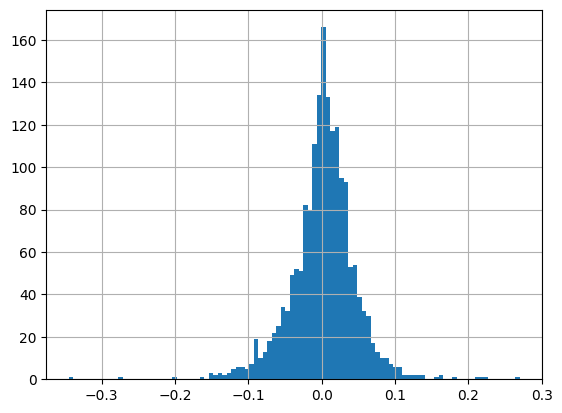

In [ ]:
# look at price volatility (closing price change) summary statistics
print(df['Close'].pct_change().describe())
df['Close'].pct_change().hist(bins=100)

In [3]:
#@title =====ADD===== Calculate the MACD

df['SMA12'] = df['Close'].rolling(12).mean()
df['SMA26'] = df['Close'].rolling(26).mean()
df['MACD'] = df['SMA12'] - df['SMA26']
df['MACD_Signal'] = df['MACD'].rolling(9).mean()
df['MACD_Diff'] = df['MACD'] - df['MACD_Signal']
df['Long'] = (df['MACD'] > df['MACD_Signal']) & (df['MACD'].shift(1) <= df['MACD_Signal'].shift(1))
df['Short'] = (df['MACD'] < df['MACD_Signal']) & (df['MACD'].shift(1) >= df['MACD_Signal'].shift(1))
df = df.dropna()


COLUMNS = ['Close','MACD', 'MACD_Signal']
df

Open       High        Low      Close  \
Date                                                                    
2020-02-20 00:00:00-05:00  28.288201  28.452191  26.621777  27.661180   
2020-02-21 00:00:00-05:00  27.265679  27.391084  25.739130  26.079166   
2020-02-24 00:00:00-05:00  23.218991  24.014824  22.579914  23.074295   
2020-02-25 00:00:00-05:00  23.616909  23.853248  20.966549  21.207710   
2020-02-26 00:00:00-05:00  21.530864  22.604032  21.017191  21.499514   
...                              ...        ...        ...        ...   
2025-02-19 00:00:00-05:00  90.000000  91.120003  88.919998  90.400002   
2025-02-20 00:00:00-05:00  90.050003  90.230003  86.889999  89.300003   
2025-02-21 00:00:00-05:00  89.769997  89.790001  83.470001  83.709999   
2025-02-24 00:00:00-05:00  84.500000  85.050003  80.500000  80.699997   
2025-02-25 00:00:00-05:00  80.330002  80.379997  75.779999  77.620003   

                              Volume  Dividends  Stock Splits  Capital Gains  \
Date                                                                           
2020-02-20 00:00:00-05:00  113828800        0.0           0.0            0.0   
2020-02-21 00:00:00-05:00  103553600        0.0           0.0            0.0   
2020-02-24 00:00:00-05:00  134837200        0.0           0.0            0.0   
2020-02-25 00:00:00-05:00  150396800        0.0           0.0            0.0   
2020-02-26 00:00:00-05:00  167868000        0.0           0.0            0.0   
...                              ...        ...           ...            ...   
2025-02-19 00:00:00-05:00   34257900        0.0           0.0            0.0   
2025-02-20 00:00:00-05:00   40133000        0.0           0.0            0.0   
2025-02-21 00:00:00-05:00   59313600        0.0           0.0            0.0   
2025-02-24 00:00:00-05:00   53233700        0.0           0.0            0.0   
2025-02-25 00:00:00-05:00   75160900        0.0           0.0            0.0   

                                  SQQQ      SMA12      SMA26      MACD  \
Date                                                                     
2020-02-20 00:00:00-05:00  1833.299438  26.884842  25.093928  1.790914   
2020-02-21 00:00:00-05:00  1938.059326  26.955382  25.209314  1.746068   
2020-02-24 00:00:00-05:00  2163.181641  26.751199  25.208572  1.542627   
2020-02-25 00:00:00-05:00  2337.038574  26.339618  25.111273  1.228345   
2020-02-26 00:00:00-05:00  2303.604492  25.980489  25.011562  0.968927   
...                                ...        ...        ...       ...   
2025-02-19 00:00:00-05:00    26.400000  86.094167  84.053846  2.040321   
2025-02-20 00:00:00-05:00    26.760000  86.809167  84.564231  2.244936   
2025-02-21 00:00:00-05:00    28.440001  86.814167  84.870000  1.944167   
2025-02-24 00:00:00-05:00    29.469999  86.477500  84.863077  1.614423   
2025-02-25 00:00:00-05:00    30.590000  85.778334  84.801154  0.977180   

                           MACD_Signal  MACD_Diff   Long  Short  
Date                                                             
2020-02-20 00:00:00-05:00     1.138229   0.652686  False  False  
2020-02-21 00:00:00-05:00     1.251998   0.494069  False  False  
2020-02-24 00:00:00-05:00     1.342783   0.199844  False  False  
2020-02-25 00:00:00-05:00     1.394842  -0.166497  False   True  
2020-02-26 00:00:00-05:00     1.394990  -0.426063  False  False  
...                                ...        ...    ...    ...  
2025-02-19 00:00:00-05:00     1.471154   0.569167  False  False  
2025-02-20 00:00:00-05:00     1.500584   0.744352  False  False  
2025-02-21 00:00:00-05:00     1.549822   0.394345  False  False  
2025-02-24 00:00:00-05:00     1.615242  -0.000819  False   True  
2025-02-25 00:00:00-05:00     1.653134  -0.675954  False  False  

[1261 rows x 16 columns]

In [ ]:
#@title =====ADD===== Plot the MACD cross over
# Rearrange the data into altair format
# altair plots interactive charts with zooming and panning
plot_data = df[COLUMNS].reset_index().melt('Date')

alt.Chart(plot_data).mark_line().encode(
  x='Date:T',
  y='value',
  color='variable'
).properties(
  width=800,
  height=600
).interactive()


alt.Chart(...)

In [6]:
#@title =====ADD===== Algo Trade use MACD cross over

InitialBalance = 1000000
Balance = InitialBalance
Last_Balance = 0
Last_Action = ""
Profit = 0
Share = 0
last_price = 0
Trial = []
#print(Symbol)
for index, row in df.iterrows():
  long_price = row['Close']
  short_price = row[short]

  if row['Long'] == True:
    Last_Action = "Long"
    if Share > 0:
      Balance = Balance + Share * short_price
      Profit = Balance / Last_Balance - 1

    Last_Balance = Balance
    last_price = long_price
    Share = math.floor(Balance / long_price)
    Balance = Balance - Share * long_price
    Trial.append(['Long',long_price,short_price,Share,Balance,Profit])
    #print('Buy', Balance, ' ',Share)

  if row['Short'] == True:
    Last_Action = "Short"
    if Share > 0:
      Balance = Balance + Share * long_price
      Profit = Balance / Last_Balance - 1

    Last_Balance = Balance
    last_price = short_price
    Share = math.floor(Balance / short_price)
    Balance = Balance - Share * short_price
    Trial.append(['Short',long_price,short_price,Share,Balance,Profit])
    #print('Sell', Balance, ' ',Share)


if Share > 0:
  if Last_Action == "Long":
    Balance = Balance + Share * long_price
  else:
    Balance = Balance + Share * short_price
  Profit = Balance / Last_Balance - 1
  Share = 0
  Trial.append(['Short',long_price,short_price,Share,Balance,Profit])
  #print('Trial',Trial)

ExchangeCount = 0
ProfitCount = 0
Probability = 0
MaxDD = 0
Profit = []
for t in Trial:
  ExchangeCount += 1
  Profit.append(t[5])
  if t[5] > 0:
    ProfitCount += 1

if ExchangeCount > 0:
  Probability = ProfitCount/ExchangeCount
  MaxDD = np.min(Profit)
  MaxG = np.max(Profit)

print('Init. Balance: 1000000')
print('Probability: ' + str(Probability))
print('Max. Gain: ' + str(MaxG))
print('Max. Drawdown: ' + str(MaxDD))
print('Balance:' + str(Trial[-1][4]))

Init. Balance: 1000000
Probability: 0.4431818181818182
Max. Gain: 0.4665905724095867
Max. Drawdown: -0.24595106135026934
Balance:686226.0155191422


In [ ]:
lead = 45 # short-term moving average days
lag = 125 # long-term moving average days

df['lead'] = df['Close'].rolling(lead).mean()
df['lag'] = df['Close'].rolling(lag).mean()

COLUMNS = ['Close', 'lead', 'lag']
df[COLUMNS]

Close        lead         lag
Date                                                         
2020-01-02 00:00:00-05:00    5.972711         NaN         NaN
2020-01-03 00:00:00-05:00    5.877110         NaN         NaN
2020-01-06 00:00:00-05:00    5.901758         NaN         NaN
2020-01-07 00:00:00-05:00    5.973209         NaN         NaN
2020-01-08 00:00:00-05:00    5.984412         NaN         NaN
...                               ...         ...         ...
2025-02-14 00:00:00-05:00  138.850006  134.133778  132.056681
2025-02-18 00:00:00-05:00  139.399994  134.230000  132.175395
2025-02-19 00:00:00-05:00  139.229996  134.228222  132.249395
2025-02-20 00:00:00-05:00  140.110001  134.289777  132.352432
2025-02-21 00:00:00-05:00  134.429993  134.293777  132.400031

[1292 rows x 3 columns]

In [ ]:
#@title Plot the SMA cross over
# Rearrange the data into altair format
# altair plots interactive charts with zooming and panning
plot_data = df[COLUMNS].reset_index().melt('Date')

alt.Chart(plot_data).mark_line().encode(
  x='Date:T',
  y='value',
  color='variable'
).properties(
  width=800,
  height=600
).interactive()

alt.Chart(...)

#3: Back testing the strategy with the historical data

Strategy Signal: (1, -1, 0)

*   **1 LONG**: if Leading SMA is above Lagging SMA by the threshold -> hold 1 long position of bitcoin
*   **-1 SHORT**: if Leading SMA is below Lagging SMA by the threshold -> short 1 bitcoin
*   **0 FLAT**: if the difference of Leading and Lagging SMA is less than the threshold -> flatten the bitcoin position


Back testing parameters
*   **lead**: short-term moving average days
*   **lag**: long-term moving average days
*   **threshold**: sensitivity of the strategy and is used to filter out weak signals. **Smaller the number means more sensitive** to the signals (which usually means more long/short positions)

In [ ]:
#@title Run back testing with different parameters

lead = 45 #@param {type:"integer"}
lag = 125 #@param {type:"integer"}
threshold = 0.1 #@param {type:"slider", min:0, max:0.5, step:0.01}

ma_df = test_ma(df, lead, lag, threshold).dropna()

SMA_COLUMNS = ['Close', 'lead', 'lag', 'lead-lag', 'pc_diff', 'signal', 'Buy-Hold', 'Strategy']
ma_df[SMA_COLUMNS]

Output hidden; open in https://colab.research.google.com to view.

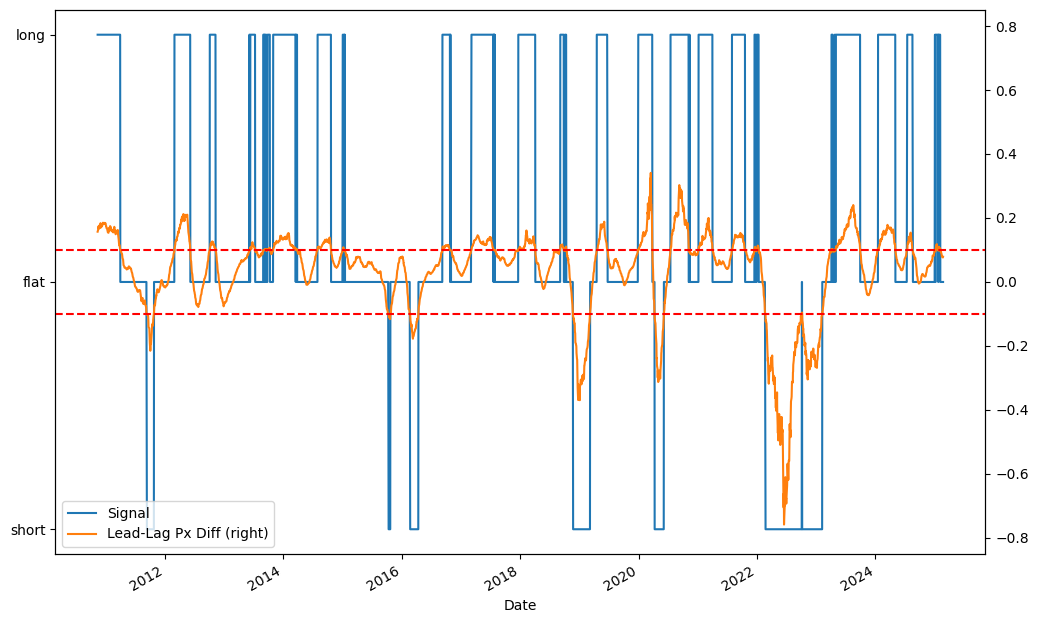

In [ ]:
#@title Plot the back test result
# Plot signal over "lead-lag" price difference (align at 0)
# Plot signal as the left y-axis
ax1 = ma_df.signal.plot(label='Signal', legend=True, figsize=(SCREEN_X, SCREEN_Y))
ax1.set_ylim(-1.1, 1.1)
plt.yticks([-1, 0, 1], ['short', 'flat', 'long'])

# Plot "lead-lag" price difference as the right y-axis
ax2 = ma_df.pc_diff.plot(secondary_y=True, label='Lead-Lag Px Diff', legend=True, figsize=(SCREEN_X, SCREEN_Y))
SAFE_MARGIN = 0.05
ylimit = max(round(ma_df.pc_diff.max(), 1), - round(ma_df.pc_diff.min(), 1)) + SAFE_MARGIN
ax2.set_ylim(-ylimit, ylimit)

plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')

### Compare Buy-hold vs SMA Strategy performance

buy_and_hold strategy which benefit from soaring bitcoin price
Strategy: SMA crossover long/short which can benefit from both soaring and dropping bit coin price (provided that the SMA predicted the price movement correctly)

In [ ]:
#@title Plot Buy-Hold vs SMA Strategy performance

print(ma_df[['Buy-Hold', 'Strategy']].iloc[-1])
ma_df[['Buy-Hold', 'Strategy']].plot(figsize = (SCREEN_X, SCREEN_Y), grid=True)

#4. Backtest the strategy with different combination to find the optimal lead/lag params

In [ ]:
# start, end, step
leads = np.arange(5, 100, 5)
lags = np.arange(105, 200, 5)

lead_lags = [[lead,lag] for lead in leads for lag in lags]
pnls = pd.DataFrame(index=lags,columns = leads)
pnls

In [ ]:
# Run the strategy with the different combination of lead/lag params
# Calculate the different between market Buy-Hold and strategy performance as PnL
for lead, lag in lead_lags:
  ma_df = test_ma(df, lead, lag, threshold)
  pnls[lead][lag] = ma_df['Strategy'][-1] - ma_df['Buy-Hold'][-1]
  print(lead, lag, pnls[lead][lag])

pnls

In [ ]:
# Use Heatmap to visualize the backtest results
PNLs = pnls[pnls.columns].astype(float)
plt.subplots(figsize = (SCREEN_X, SCREEN_Y))
sns.heatmap(PNLs, cmap='coolwarm', annot=True, cbar_kws={'orientation': 'horizontal'})

In [ ]:
# Run again with the best lead/lag SMA combinations
lead = 5
lag = 105

ma_df = test_ma(df, lead, lag, threshold).dropna()
ma_df[['Buy-Hold', 'Strategy']].plot(figsize = (SCREEN_X, SCREEN_Y), grid=True)
ma_df[['Buy-Hold', 'Strategy']].iloc[-1]

#5. Show the performance details of SMA strategy

In [ ]:
pf.create_full_tear_sheet(ma_df['Strategy'].pct_change())

**Suggestions**

1. Backtest with different **threshold** values
2. Separate the data into 2 portions (**research & back-test**). Optimize the lead/lag/threshold params from the research portion and use back-test data to measure the strategy performance
3. Try different Technical Analysis signals such as **RSI, Bollinger Bands** with TA-Lib (https://pypi.org/project/TA-Lib/)
4. Try other cryptos (e.g. ETH-USD) or stocks (e.g. 0005.HK)
5. Try different data source: https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/DataSource.ipynb
